In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import time
import math
from google.colab import drive

# --- Configuration ---
FILE_PATH = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/gongguan_model_ready_features.parquet.gz"
GMAN_DATA_DIR = "/content/drive/MyDrive/Youbike_Master_Project/GMAN_data/"
TRAFFIC_FILE = os.path.join(GMAN_DATA_DIR, "youbike_traffic.h5")
SE_FILE = os.path.join(GMAN_DATA_DIR, "youbike_SE.txt")
MODEL_DIR = "/content/drive/MyDrive/Youbike_Master_Project/GMAN_Checkpoints_TF2/"
LOG_DIR = "/content/drive/MyDrive/Youbike_Master_Project/GMAN_logs_TF2/"

# --- Mount Drive and Create Directories ---
drive.mount('/content/drive')
os.makedirs(GMAN_DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
print("✅ Google Drive mounted and directories are ready.")
print(f"TensorFlow Version: {tf.__version__}")

Mounted at /content/drive
✅ Google Drive mounted and directories are ready.
TensorFlow Version: 2.19.0


In [ ]:
print("\n--- Restructuring data for GMAN... ---")
# Load your pre-processed data
data = pd.read_parquet(FILE_PATH)
data['time'] = pd.to_datetime(data['time']) # Ensure time column is datetime

# --- ADD THIS BLOCK TO CREATE A SMALL SAMPLE ---
print("\n--- Creating a small sample for a quick test run... ---")
sample_station_ids = data['sno'].unique()[:3] # Select the first 3 unique stations
data = data[data['sno'].isin(sample_station_ids)].copy()
print(f"✅ Sample created with {len(sample_station_ids)} stations.")
# --- END OF SAMPLE BLOCK ---


# --- 2.1: Create the Traffic Matrix ---
print("Pivoting data to create traffic matrix (Timestamps x Stations)...")

# Create Traffic Matrix
traffic_df = data.pivot(index='time', columns='sno', values='occupancy_ratio')
traffic_df = traffic_df.resample('10T').mean().ffill()
traffic_df.to_hdf(TRAFFIC_FILE, key='df', mode='w')
print(f"✅ Traffic data shape: {traffic_df.shape}. Saved to: {TRAFFIC_FILE}")

# Create Spatial Embedding File
stations = data[['sno', 'lat', 'lng']].drop_duplicates('sno').set_index('sno')
stations = stations.reindex(traffic_df.columns)
with open(SE_FILE, 'w') as f:
    num_stations, embedding_dim = stations.shape[0], 2
    f.write(f"{num_stations} {embedding_dim}\n")
    for station_idx, row in enumerate(stations.itertuples()):
        f.write(f"{station_idx} {row.lat} {row.lng}\n")
print(f"✅ Spatial Embedding file saved to: {SE_FILE}")


--- Restructuring data for GMAN... ---

--- Creating a small sample for a quick test run... ---
✅ Sample created with 3 stations.
Pivoting data to create traffic matrix (Timestamps x Stations)...


/tmp/ipython-input-2709526743.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_df = traffic_df.resample('10T').mean().ffill()


✅ Traffic data shape: (59760, 3). Saved to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_data/youbike_traffic.h5
✅ Spatial Embedding file saved to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_data/youbike_SE.txt


In [ ]:
# --- Utility Functions ---
def log_string(log, string):
    log.write(string + '\n'); log.flush(); print(string)

def metric(pred, label):
    mask = np.not_equal(label, 0).astype(np.float32)
    mask /= np.mean(mask)
    mae = np.mean(np.abs(pred - label) * mask)
    rmse = np.sqrt(np.mean((pred - label)**2 * mask))
    return mae, rmse

def seq2instance(data, P, Q):
    num_step, dims = data.shape
    num_sample = num_step - P - Q + 1
    x = np.zeros((num_sample, P, dims)); y = np.zeros((num_sample, Q, dims))
    for i in range(num_sample):
        x[i] = data[i: i + P]; y[i] = data[i + P: i + P + Q]
    return x, y

def load_data(args):
    df = pd.read_hdf(args.traffic_file)
    traffic = df.values
    num_step = df.shape[0]
    train_steps = round(args.train_ratio * num_step)
    val_steps = round(args.val_ratio * num_step)
    train = traffic[:train_steps]; val = traffic[train_steps : train_steps + val_steps]; test = traffic[-(num_step - train_steps - val_steps):]
    trainX, trainY = seq2instance(train, args.P, args.Q)
    valX, valY = seq2instance(val, args.P, args.Q)
    testX, testY = seq2instance(test, args.P, args.Q)
    mean, std = np.mean(trainX), np.std(trainX)
    trainX = (trainX - mean) / std; valX = (valX - mean) / std; testX = (testX - mean) / std

    with open(args.SE_file, 'r') as f:
        lines = f.readlines()
        temp = lines[0].split(' '); N, dims = int(temp[0]), int(temp[1])
        SE = np.zeros((N, dims), dtype=np.float32)
        for line in lines[1:]:
            temp = line.split(' '); index = int(temp[0]); SE[index] = temp[1:]

    Time = df.index
    dayofweek = np.reshape(Time.weekday, (-1, 1))
    timeofday = (Time.hour * 60 + Time.minute) // 10
    timeofday = np.reshape(timeofday, (-1, 1))
    Time = np.concatenate((dayofweek, timeofday), axis=-1)
    trainTE = np.concatenate(seq2instance(Time[:train_steps], args.P, args.Q), axis=1).astype(np.int32)
    valTE = np.concatenate(seq2instance(Time[train_steps: train_steps + val_steps], args.P, args.Q), axis=1).astype(np.int32)
    testTE = np.concatenate(seq2instance(Time[-(num_step - train_steps - val_steps):], args.P, args.Q), axis=1).astype(np.int32)
    return trainX, trainTE, trainY, valX, valTE, valY, testX, testTE, testY, SE, mean, std

# --- Keras Layers for GMAN ---
class FullyConnected(layers.Layer):
    def __init__(self, units, activations, use_bias=True):
        super(FullyConnected, self).__init__()
        if isinstance(units, int): units = [units]; activations = [activations]
        self.convs = []
        for num_unit, activation in zip(units, activations):
            self.convs.append(layers.Conv2D(num_unit, kernel_size=1, activation=activation, use_bias=use_bias))
    def call(self, x):
        for conv in self.convs: x = conv(x)
        return x

class STEmbedding(layers.Layer):
    def __init__(self, D):
        super(STEmbedding, self).__init__()
        self.FC_se = FullyConnected([D, D], [tf.nn.relu, None])
        self.day_embed = layers.Embedding(7, D)
        self.time_embed = layers.Embedding(24 * 6, D) # 144 10-minute intervals in a day

    def call(self, SE, TE):
        # 1. Process the Spatial Embedding (SE)
        # Shape: (num_stations, 2) -> (1, 1, num_stations, D)
        SE = self.FC_se(tf.expand_dims(tf.expand_dims(SE, 0), 0))

        # 2. Process the Temporal Embeddings (TE)
        # Shape: (batch_size, seq_len, D)
        day_TE = self.day_embed(TE[..., 0])
        time_TE = self.time_embed(TE[..., 1])

        # --- THIS IS THE FIX ---
        # 3. Reshape TE to make it broadcastable with SE
        # We add a dimension for the number of stations.
        # Shape: (batch_size, seq_len, D) -> (batch_size, seq_len, 1, D)
        day_TE = tf.expand_dims(day_TE, axis=2)
        time_TE = tf.expand_dims(time_TE, axis=2)
        # --- END OF FIX ---

        # 4. Add the embeddings together. Broadcasting handles the rest.
        # (1, 1, num_stations, D) + (batch, seq, 1, D) -> (batch, seq, num_stations, D)
        return SE + day_TE + time_TE

class SpatialAttention(layers.Layer):
    def __init__(self, K, d):
        super(SpatialAttention, self).__init__()
        self.K, self.d = K, d
        self.D = K * d
        self.FC_q = FullyConnected(self.D, tf.nn.relu)
        self.FC_k = FullyConnected(self.D, tf.nn.relu)
        self.FC_v = FullyConnected(self.D, tf.nn.relu)
        self.FC_o = FullyConnected(self.D, tf.nn.relu)
    def call(self, X, STE):
        query = self.FC_q(X); key = self.FC_k(X); value = self.FC_v(X)
        query = tf.concat(tf.split(query, self.K, axis=-1), axis=0)
        key = tf.concat(tf.split(key, self.K, axis=-1), axis=0)
        value = tf.concat(tf.split(value, self.K, axis=-1), axis=0)
        STE = tf.concat(tf.split(STE, self.K, axis=-1), axis=0)
        query += STE; key += STE
        attention = tf.matmul(query, key, transpose_b=True) / (self.d ** 0.5)
        attention = tf.nn.softmax(attention)
        X_ = tf.matmul(attention, value)
        X_ = tf.concat(tf.split(X_, self.K, axis=0), axis=-1)
        return self.FC_o(X_)

class TemporalAttention(layers.Layer):
    def __init__(self, K, d):
        super(TemporalAttention, self).__init__()
        self.K, self.d = K, d
        self.D = K * d
        self.FC_q = FullyConnected(self.D, tf.nn.relu)
        self.FC_k = FullyConnected(self.D, tf.nn.relu)
        self.FC_v = FullyConnected(self.D, tf.nn.relu)
        self.FC_o = FullyConnected(self.D, tf.nn.relu)
    def call(self, X, STE):
        query = self.FC_q(X); key = self.FC_k(X); value = self.FC_v(X)
        query = tf.concat(tf.split(query, self.K, axis=-1), axis=0)
        key = tf.concat(tf.split(key, self.K, axis=-1), axis=0)
        value = tf.concat(tf.split(value, self.K, axis=-1), axis=0)
        STE = tf.concat(tf.split(STE, self.K, axis=-1), axis=0)
        query += STE; key += STE
        query = tf.transpose(query, (0, 2, 1, 3))
        key = tf.transpose(key, (0, 2, 3, 1))
        value = tf.transpose(value, (0, 2, 1, 3))
        attention = tf.matmul(query, key) / (self.d ** 0.5)
        attention = tf.nn.softmax(attention)
        X_ = tf.matmul(attention, value)
        X_ = tf.transpose(X_, (0, 2, 1, 3))
        X_ = tf.concat(tf.split(X_, self.K, axis=0), axis=-1)
        return self.FC_o(X_)

class GatedFusion(layers.Layer):
    def __init__(self, D):
        super(GatedFusion, self).__init__()
        self.FC_gate = FullyConnected(D, tf.nn.sigmoid)
    def call(self, X_s, X_t):
        gate = self.FC_gate(tf.concat([X_s, X_t], axis=-1))
        return gate * X_s + (1 - gate) * X_t

class STAttBlock(layers.Layer):
    def __init__(self, K, d):
        super(STAttBlock, self).__init__()
        self.spatial_attention = SpatialAttention(K, d)
        self.temporal_attention = TemporalAttention(K, d)
        self.gated_fusion = GatedFusion(K * d)
    def call(self, X, STE):
        X_s = self.spatial_attention(X, STE)
        X_t = self.temporal_attention(X, STE)
        return self.gated_fusion(X_s, X_t)

class TransformAttention(layers.Layer):
    def __init__(self, K, d):
        super(TransformAttention, self).__init__()
        self.K, self.d = K, d
        self.D = K * d
        self.FC_q = FullyConnected(self.D, tf.nn.relu)
        self.FC_k = FullyConnected(self.D, tf.nn.relu)
        self.FC_v = FullyConnected(self.D, tf.nn.relu)
        self.FC_o = FullyConnected(self.D, tf.nn.relu)
    def call(self, X, STE_P, STE_Q):
        query = self.FC_q(STE_Q); key = self.FC_k(STE_P); value = self.FC_v(X)
        query = tf.concat(tf.split(query, self.K, axis=-1), axis=0)
        key = tf.concat(tf.split(key, self.K, axis=-1), axis=0)
        value = tf.concat(tf.split(value, self.K, axis=-1), axis=0)
        query = tf.transpose(query, (0, 2, 1, 3))
        key = tf.transpose(key, (0, 2, 3, 1))
        value = tf.transpose(value, (0, 2, 1, 3))
        attention = tf.matmul(query, key) / (self.d ** 0.5)
        attention = tf.nn.softmax(attention)
        X_ = tf.matmul(attention, value)
        X_ = tf.transpose(X_, (0, 2, 1, 3))
        X_ = tf.concat(tf.split(X_, self.K, axis=0), axis=-1)
        return self.FC_o(X_)

class GMAN(keras.Model):
    def __init__(self, L, K, d, P, Q):
        super(GMAN, self).__init__()
        self.L, self.K, self.d, self.P, self.Q = L, K, d, P, Q
        self.D = K * d
        self.FC_input = FullyConnected([self.D, self.D], [tf.nn.relu, None])
        self.STEmbedding = STEmbedding(self.D)
        self.encoder = [STAttBlock(K, d) for _ in range(L)]
        self.transform_attention = TransformAttention(K, d)
        self.decoder = [STAttBlock(K, d) for _ in range(L)]
        self.FC_output = FullyConnected([self.D, 1], [tf.nn.relu, None])
    def call(self, X, SE, TE):
        X = self.FC_input(tf.expand_dims(X, -1))
        STE = self.STEmbedding(SE, TE)
        STE_P, STE_Q = STE[:, :self.P], STE[:, self.P:]
        for block in self.encoder: X = block(X, STE_P)
        X = self.transform_attention(X, STE_P, STE_Q)
        for block in self.decoder: X = block(X, STE_Q)
        return tf.squeeze(self.FC_output(X), -1)

print("✅ GMAN model and utility functions defined for TensorFlow 2.x.")

✅ GMAN model and utility functions defined for TensorFlow 2.x.


Number of training samples: 41815

--- Starting Model Training ---
Epoch  1, Val MAE: 0.2675, Time: 19.28s
  > Save model to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_Checkpoints_TF2/gman_model_tf2.weights.h5
Epoch  2, Val MAE: 0.2666, Time: 9.63s
  > Save model to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_Checkpoints_TF2/gman_model_tf2.weights.h5
Epoch  3, Val MAE: 0.2658, Time: 9.38s
  > Save model to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_Checkpoints_TF2/gman_model_tf2.weights.h5
Epoch  4, Val MAE: 0.2655, Time: 9.39s
  > Save model to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_Checkpoints_TF2/gman_model_tf2.weights.h5
Epoch  5, Val MAE: 0.2654, Time: 9.29s
  > Save model to: /content/drive/MyDrive/Youbike_Master_Project/GMAN_Checkpoints_TF2/gman_model_tf2.weights.h5
Epoch  6, Val MAE: 0.2655, Time: 9.25s
Epoch  7, Val MAE: 0.2657, Time: 9.31s
Epoch  8, Val MAE: 0.2659, Time: 9.30s
Epoch  9, Val MAE: 0.2659, Time: 9.31s
Epoch 10, Val MAE: 0.

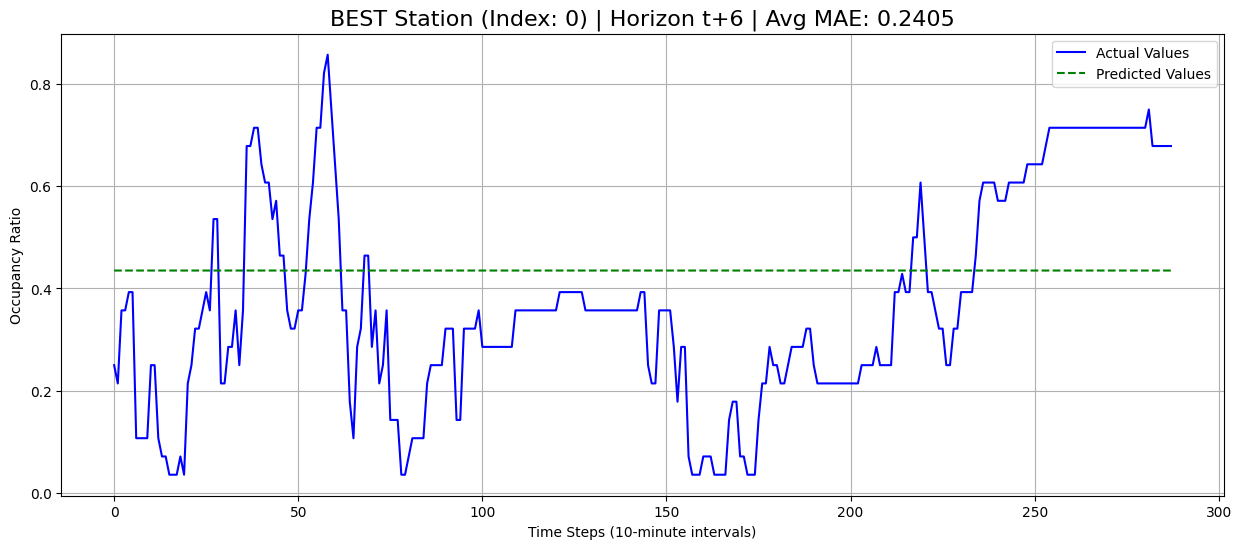

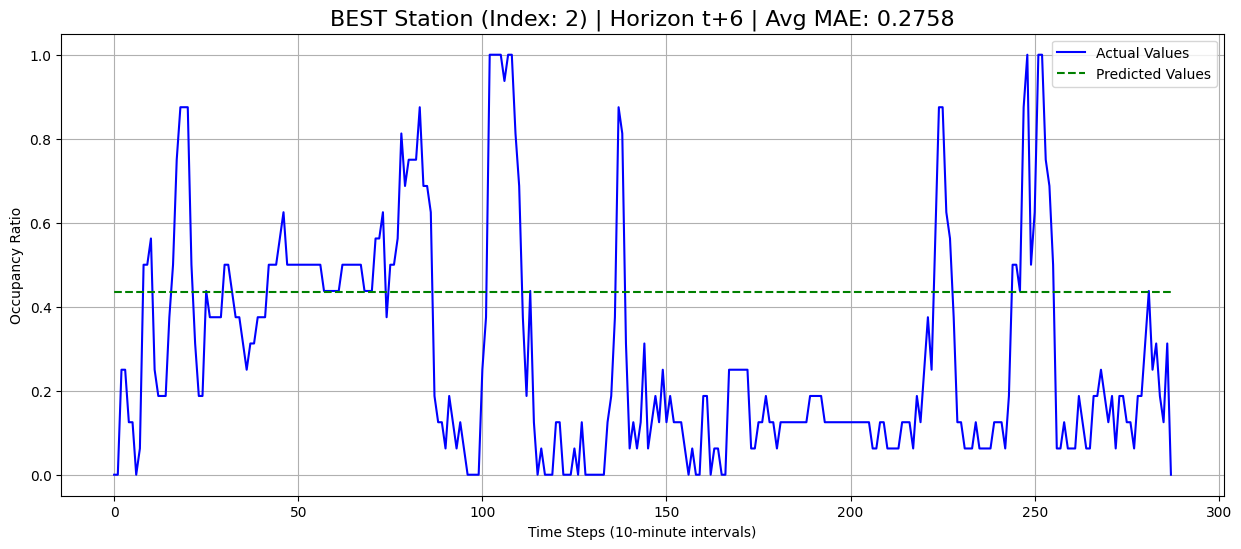

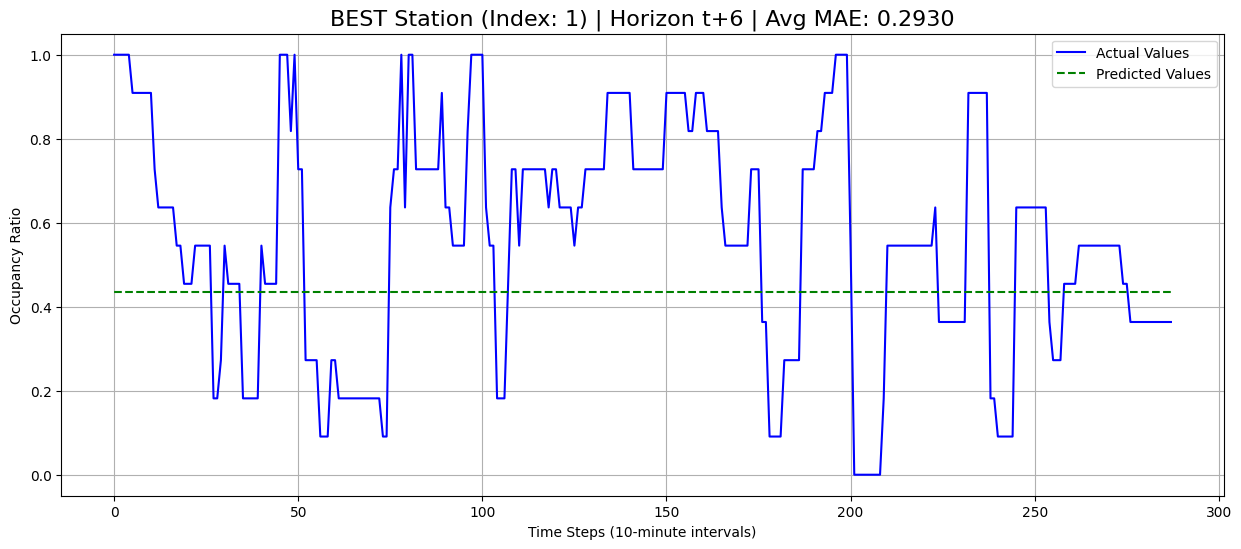


--- Visualizing t+6 Forecasts for WORST Stations ---


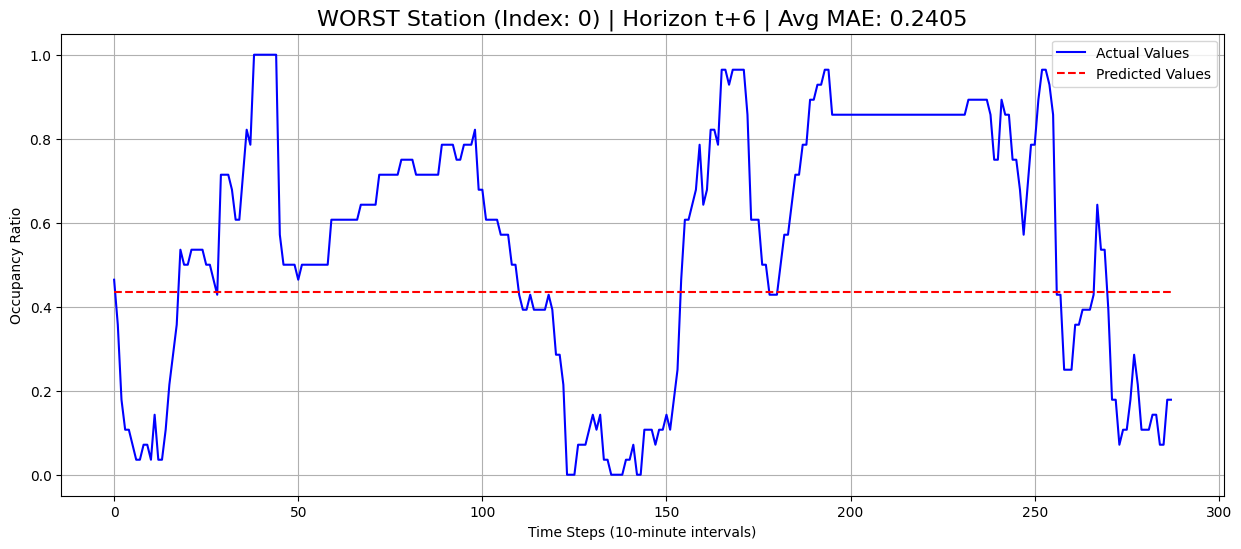

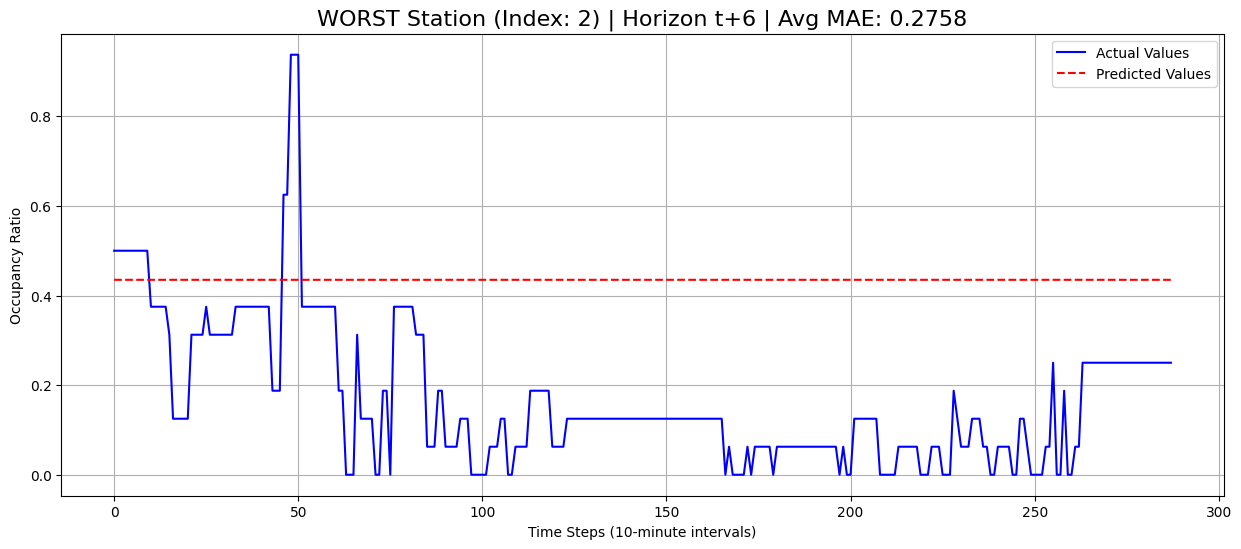

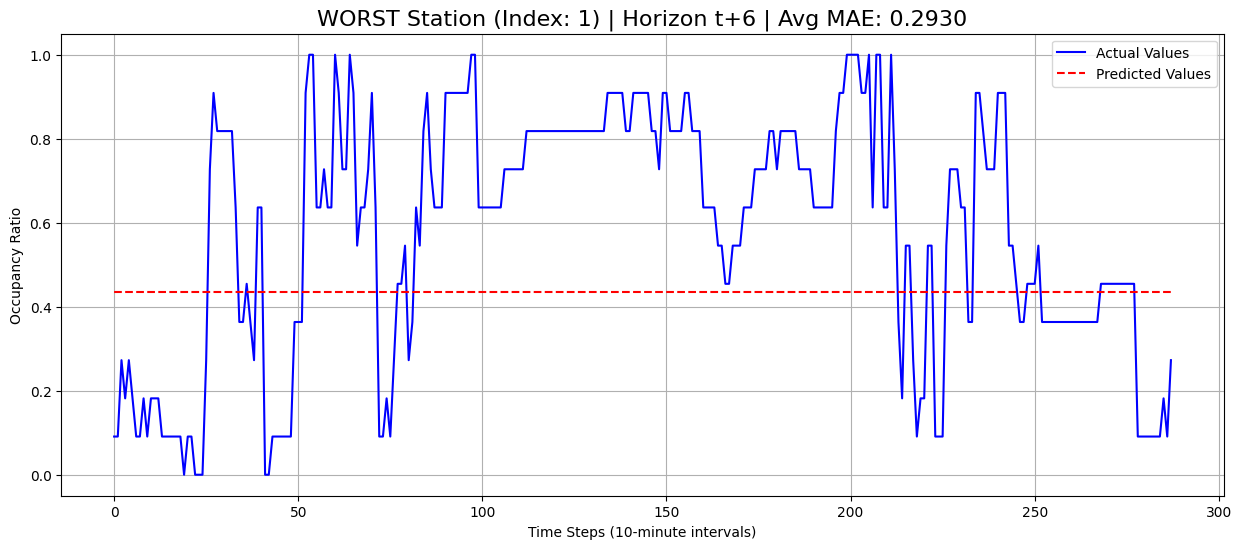

In [ ]:
# ==============================================================================
# Final Cell: GMAN Training and Comprehensive Evaluation
# ==============================================================================
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Set Hyperparameters ---
class Args:
    P = 12; Q = 6; L = 5; K = 8; d = 8
    train_ratio = 0.7; val_ratio = 0.15; test_ratio = 0.15
    batch_size = 8192; max_epoch = 100; patience = 10
    learning_rate = 0.001
    traffic_file = TRAFFIC_FILE
    SE_file = SE_FILE
    model_file = os.path.join(MODEL_DIR, "gman_model_tf2.weights.h5")

args = Args()

# --- 2. Load Data ---
trainX, trainTE, trainY, valX, valTE, valY, testX, testTE, testY, SE, mean, std = load_data(args)
print(f'Number of training samples: {trainX.shape[0]}')

# --- 3. Build and Compile Model ---
model = GMAN(args.L, args.K, args.d, args.P, args.Q)
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)
loss_fn = tf.keras.losses.MeanAbsoluteError()

# --- 4. Training Loop ---
print("\n--- Starting Model Training ---")
wait = 0; val_loss_min = np.inf
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainTE, trainY)).batch(args.batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((valX, valTE, valY)).batch(args.batch_size)

for epoch in range(args.max_epoch):
    start_time = time.time()
    for step, (x_batch, te_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            pred = model(x_batch, SE, te_batch) * std + mean
            loss = loss_fn(y_batch, pred)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    val_loss = 0
    for x_batch, te_batch, y_batch in val_dataset:
        pred = model(x_batch, SE, te_batch, training=False) * std + mean
        val_loss += loss_fn(y_batch, pred) * x_batch.shape[0]
    val_loss /= valX.shape[0]

    print(f'Epoch {epoch+1:2d}, Val MAE: {val_loss:.4f}, Time: {time.time() - start_time:.2f}s')
    if val_loss < val_loss_min:
        wait = 0; val_loss_min = val_loss
        model.save_weights(args.model_file)
        print(f'  > Save model to: {args.model_file}')
    else:
        wait += 1
    if wait >= args.patience:
        print(f'  > Early stop at epoch {epoch+1}')
        break

# --- 5. Final Evaluation on TEST SET ---
print("\n\n--- Final Detailed Evaluation on Test Set ---")
model.load_weights(args.model_file)

# Generate predictions using a manual loop
print("\nGenerating predictions on the test set...")
test_preds = []
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testTE)).batch(args.batch_size)
for x_batch, te_batch in test_dataset:
    pred_batch = model(x_batch, SE, te_batch, training=False) * std + mean
    test_preds.append(pred_batch.numpy())
test_preds = np.concatenate(test_preds, axis=0)
print("✅ Test set predictions generated.")

# --- 5.1: Per-Horizon and Overall Metrics ---
print('\n--- Test Set Metrics for Each Horizon ---')
for q in range(args.Q):
    y_true_step = testY[:, q, :]
    y_pred_step = test_preds[:, q, :]
    mae = mean_absolute_error(y_true_step, y_pred_step)
    mse = mean_squared_error(y_true_step, y_pred_step)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_step, y_pred_step, multioutput='uniform_average')
    print(f"  Horizon t+{q+1}: MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

print("\n--- Overall Average Test Set Metrics (All Stations) ---")
y_true_flat = testY.ravel(); y_pred_flat = test_preds.ravel()
print(f"  Overall MAE:  {mean_absolute_error(y_true_flat, y_pred_flat):.4f}")
print(f"  Overall MSE:  {mean_squared_error(y_true_flat, y_pred_flat):.4f}")
print(f"  Overall RMSE: {np.sqrt(mean_squared_error(y_true_flat, y_pred_flat)):.4f}")
print(f"  Overall R²:   {r2_score(y_true_flat, y_pred_flat):.4f}")

# --- 5.2: Identify and Analyze Best/Worst Stations ---
print("\n\n--- Best vs. Worst Station Analysis ---")
num_stations = testY.shape[2]
station_errors = [{'station_idx': i, 'mae': np.mean(np.abs(testY[:, :, i] - test_preds[:, :, i]))} for i in range(num_stations)]
errors_df = pd.DataFrame(station_errors).sort_values('mae')
best_stations_indices = errors_df.head(3)['station_idx'].tolist()
worst_stations_indices = errors_df.tail(3)['station_idx'].tolist()

def calculate_subset_metrics(indices):
    y_true_subset = testY[:, :, indices].ravel()
    y_pred_subset = test_preds[:, :, indices].ravel()
    mae = mean_absolute_error(y_true_subset, y_pred_subset)
    rmse = np.sqrt(mean_squared_error(y_true_subset, y_pred_subset))
    r2 = r2_score(y_true_subset, y_pred_subset)
    return mae, rmse, r2

metrics_best_3 = calculate_subset_metrics(best_stations_indices)
metrics_worst_3 = calculate_subset_metrics(worst_stations_indices)
print(f"\n--- Metrics for the 3 BEST Stations (Indices: {best_stations_indices}) ---")
print(f"  Best 3 MAE: {metrics_best_3[0]:.4f}, RMSE: {metrics_best_3[1]:.4f}, R²: {metrics_best_3[2]:.4f}")
print(f"\n--- Metrics for the 3 WORST Stations (Indices: {worst_stations_indices}) ---")
print(f"  Worst 3 MAE: {metrics_worst_3[0]:.4f}, RMSE: {metrics_worst_3[1]:.4f}, R²: {metrics_worst_3[2]:.4f}")

# --- 5.3: Plot Forecasts for Best and Worst Stations ---
horizon_to_plot = 5 # Corresponds to t+6 (0-indexed)

def plot_station_forecast(station_idx, performance_type, color):
    steps_to_plot = 288 # 2 days
    start_index = np.random.randint(0, testY.shape[0] - steps_to_plot)
    y_actual_slice = testY[start_index : start_index + steps_to_plot, horizon_to_plot, station_idx]
    y_pred_slice = test_preds[start_index : start_index + steps_to_plot, horizon_to_plot, station_idx]
    mae = errors_df[errors_df['station_idx'] == station_idx]['mae'].iloc[0]

    # Filter out invalid typhoon data for plotting
    valid_indices = y_actual_slice >= 0

    plt.figure(figsize=(15, 6))
    plt.plot(y_actual_slice[valid_indices], label='Actual Values', color='blue')
    plt.plot(y_pred_slice[valid_indices], label='Predicted Values', color=color, linestyle='--')
    plt.title(f'{performance_type} Station (Index: {station_idx}) | Horizon t+{horizon_to_plot+1} | Avg MAE: {mae:.4f}', fontsize=16)
    plt.xlabel('Time Steps (10-minute intervals)'); plt.ylabel('Occupancy Ratio')
    plt.legend(); plt.grid(True);
    plt.show()

print(f"\n--- Visualizing t+6 Forecasts for BEST Stations ---")
for station_idx in best_stations_indices:
    plot_station_forecast(station_idx, "BEST", "green")

print(f"\n--- Visualizing t+6 Forecasts for WORST Stations ---")
for station_idx in worst_stations_indices:
    plot_station_forecast(station_idx, "WORST", "red")

In [ ]:
# ==============================================================================
# Final Cell: Comprehensive Evaluation on the TEST SET
# ==============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Generate Predictions on the TEST SET ---
print("\n--- Final Evaluation on Test Set ---")
model.load_weights(args.model_file)

# Generate predictions using a manual loop
print("\nGenerating predictions on the test set...")
test_preds = []
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testTE)).batch(args.batch_size)
for x_batch, te_batch in test_dataset:
    pred_batch = model(x_batch, SE, te_batch, training=False) * std + mean
    test_preds.append(pred_batch.numpy())
test_preds = np.concatenate(test_preds, axis=0)
print("✅ Test set predictions generated.")


# --- 2. Per-Horizon and Overall Metrics ---
print('\n--- Test Set Metrics for Each Horizon ---')
for q in range(args.Q):
    y_true_step = testY[:, q, :]
    y_pred_step = test_preds[:, q, :]

    mae = mean_absolute_error(y_true_step, y_pred_step)
    mse = mean_squared_error(y_true_step, y_pred_step)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_step, y_pred_step, multioutput='uniform_average')

    print(f"\n--- Horizon t+{q+1} (+{(q+1)*10} min) ---")
    print(f"MAE:  {mae:.4f}, MSE:  {mse:.4f}, RMSE: {rmse:.4f}, R²:   {r2:.4f}")

# Calculate overall average metrics by flattening the arrays
print("\n--- Overall Average Test Set Metrics (All Stations) ---")
y_true_flat = testY.ravel()
y_pred_flat = test_preds.ravel()
overall_mae = mean_absolute_error(y_true_flat, y_pred_flat)
overall_mse = mean_squared_error(y_true_flat, y_pred_flat)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(y_true_flat, y_pred_flat)

print(f"Overall MAE:  {overall_mae:.4f}")
print(f"Overall MSE:  {overall_mse:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall R²:   {overall_r2:.4f}")


# --- 3. Identify and Analyze Best/Worst Performing Stations ---
print("\n\n--- Best vs. Worst Station Analysis ---")
print("\nCalculating Mean Absolute Error for each station...")
num_stations = testY.shape[2]
station_errors = [{'station_idx': i, 'mae': np.mean(np.abs(testY[:, :, i] - test_preds[:, :, i]))} for i in range(num_stations)]

# Sort stations by error to find the best and worst
errors_df = pd.DataFrame(station_errors).sort_values('mae')
best_stations_indices = errors_df.head(3)['station_idx'].tolist()
worst_stations_indices = errors_df.tail(3)['station_idx'].tolist()
print("✅ Best and worst stations identified.")

# Helper function to calculate metrics for a subset of stations
def calculate_subset_metrics(indices):
    y_true_subset = testY[:, :, indices].ravel()
    y_pred_subset = test_preds[:, :, indices].ravel()
    mae = mean_absolute_error(y_true_subset, y_pred_subset)
    rmse = np.sqrt(mean_squared_error(y_true_subset, y_pred_subset))
    r2 = r2_score(y_true_subset, y_pred_subset)
    return mae, rmse, r2

# Calculate and display metrics for the subsets
metrics_best_3 = calculate_subset_metrics(best_stations_indices)
metrics_worst_3 = calculate_subset_metrics(worst_stations_indices)

print("\n--- Average Metrics for the 3 BEST Performing Stations ---")
print(f"(Station Indices: {best_stations_indices})")
print(f"Best 3 MAE:   {metrics_best_3[0]:.4f}, RMSE: {metrics_best_3[1]:.4f}, R²: {metrics_best_3[2]:.4f}")

print("\n--- Average Metrics for the 3 WORST Performing Stations ---")
print(f"(Station Indices: {worst_stations_indices})")
print(f"Worst 3 MAE:  {metrics_worst_3[0]:.4f}, RMSE: {metrics_worst_3[1]:.4f}, R²: {metrics_worst_3[2]:.4f}")


# --- 4. Plot Forecasts for Best and Worst Stations ---
horizon_to_plot = 5 # Corresponds to t+6 (0-indexed)

def plot_station_forecast(station_idx, performance_type, color):
    # Select a random 2-day slice of the test data for plotting
    steps_to_plot = 288
    start_index = np.random.randint(0, testY.shape[0] - steps_to_plot)
    y_actual_slice = testY[start_index : start_index + steps_to_plot, horizon_to_plot, station_idx]
    y_pred_slice = test_preds[start_index : start_index + steps_to_plot, horizon_to_plot, station_idx]
    mae = errors_df[errors_df['station_idx'] == station_idx]['mae'].iloc[0]

    plt.figure(figsize=(15, 6))
    plt.plot(y_actual_slice, label='Actual Values', color='blue')
    plt.plot(y_pred_slice, label='Predicted Values', color=color, linestyle='--')
    plt.title(f'{performance_type} Performing Station (Index: {station_idx}) | Avg MAE: {mae:.4f}', fontsize=16)
    plt.xlabel(f'Time Steps (10-minute intervals, Horizon t+{horizon_to_plot+1})'); plt.ylabel('Occupancy Ratio')
    plt.legend(); plt.grid(True); plt.ylim(0, 1)
    plt.show()

print(f"\n--- Visualizing t+6 Forecasts for BEST Stations ---")
for station_idx in best_stations_indices:
    plot_station_forecast(station_idx, "BEST", "green")

print(f"\n--- Visualizing t+6 Forecasts for WORST Stations ---")
for station_idx in worst_stations_indices:
    plot_station_forecast(station_idx, "WORST", "red")

In [ ]:
import pandas as pd

# Define the file path and cutoff date from your script
FILE_PATH = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/gongguan_model_ready_features.parquet.gz"
VALIDATION_CUTOFF_DATE = '2024-09-20'

# Load the data to find the date range
data = pd.read_parquet(FILE_PATH)
data['time'] = pd.to_datetime(data['time'])

# Determine the start and end dates of the test set
test_set_start = data[data['time'] > VALIDATION_CUTOFF_DATE]['time'].min()
test_set_end = data[data['time'] > VALIDATION_CUTOFF_DATE]['time'].max()

print(f"Test set starts on: {test_set_start}")
print(f"Test set ends on:   {test_set_end}")

Test set starts on: 2024-09-20 00:10:00
Test set ends on:   2025-06-22 23:50:00
